In [195]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.autograd import Variable

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [196]:
 # Data load

data = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949')
data = data.iloc[:-1,:]
data

,date,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
0,2013-01-01,63.4,67.8,77.7,60.5,68.1,53.0,92.6,92.6,66.8,...,92.6,71.1,73.0,82.4,82.0,102.8,93.6,59.7,83.2,1
1,2013-02-01,63.3,67.2,77.4,60.2,67.7,52.9,92.5,90.9,66.6,...,92.8,70.9,72.9,82.0,81.7,102.8,93.6,59.1,83.0,1
2,2013-03-01,63.2,66.9,76.9,60.0,67.4,52.6,92.4,90.1,66.3,...,92.8,70.8,72.8,81.9,81.4,102.7,93.6,58.7,82.9,1
3,2013-04-01,63.3,67.1,76.4,59.8,67.4,52.6,92.4,90.0,66.3,...,93.5,70.7,73.2,82.3,81.7,102.7,93.9,58.6,82.9,1
4,2013-05-01,63.4,67.5,76.4,59.6,67.6,52.9,92.4,89.8,66.6,...,93.8,71.0,73.6,82.3,81.9,103.6,94.7,58.8,82.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,108.4,104.3,106.5,110.5,108.7,106.7,111.7,107.3,109.3,...,112.6,104.7,110.9,106.8,108.5,105.2,107.3,111.5,114.1,0
106,2021-11-01,109.5,104.8,107.2,111.7,110.2,107.3,113.2,107.7,110.7,...,114.8,105.3,111.6,107.9,109.5,106.6,108.4,112.9,115.9,0
107,2021-12-01,109.8,105.1,107.4,112.0,110.8,107.4,114.1,107.5,111.2,...,116.1,105.6,111.6,108.4,109.8,107.2,109.0,113.0,116.7,0
108,2022-01-01,109.8,105.1,107.4,111.8,110.8,107.3,114.3,107.5,111.3,...,116.9,105.6,111.5,108.7,109.8,107.1,109.2,113.0,116.8,0


In [197]:
df = pd.read_csv('경기도변수.csv')
df

,date,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
0,2013-01-01,73.5,64.75625,93.900000,80.1,102.868,92.728,5.78,82.689331,76.007636,1089.0,1841.1,1961.90,503.67,8413721.0,54632,13631
1,2013-02-01,73.2,64.42500,93.666667,79.8,90.009,93.038,5.66,82.871183,76.108044,1083.0,1857.1,2026.50,535.87,7268443.0,65640,14925
2,2013-03-01,73.1,64.22500,93.550000,79.6,101.388,92.952,5.54,83.162722,76.376687,1111.0,1862.4,2004.90,555.02,10160177.0,87563,17718
3,2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,1867.7,1964.00,563.87,9757932.0,106498,22790
4,2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,1870.3,2001.05,577.87,10837979.0,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,3543.4,2970.68,992.33,14689855.0,119686,29187
106,2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,3594.7,2839.01,965.63,14483042.0,111172,26593
107,2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,3620.1,2977.65,1033.98,19169150.0,101766,25669
108,2022-01-01,104.4,108.75000,111.383333,110.3,115.100,104.690,3.75,103.250891,104.790872,1205.5,3634.3,2663.34,872.87,13736304.0,87825,20544


lag 변수 생성

In [198]:
df.set_index('date', inplace=True)

In [199]:
lag_col= list(df.columns)

In [200]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
        
df.dropna(inplace=True)

In [201]:
df

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,...,503.67,10160177.0,7268443.0,8413721.0,87563.0,65640.0,54632.0,17718.0,14925.0,13631.0
2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,...,535.87,9757932.0,10160177.0,7268443.0,106498.0,87563.0,65640.0,22790.0,17718.0,14925.0
2013-06-01,73.2,64.55000,94.300000,79.5,99.722,92.710,5.05,83.978080,77.265688,1142.0,...,555.02,10837979.0,9757932.0,10160177.0,120393.0,106498.0,87563.0,25910.0,22790.0,17718.0
2013-07-01,72.8,64.36875,94.233333,79.1,99.907,92.909,5.09,84.230581,77.474299,1123.5,...,563.87,10007009.0,10837979.0,9757932.0,160468.0,120393.0,106498.0,33741.0,25910.0,22790.0
2013-08-01,72.5,64.17500,94.083333,78.8,96.115,93.238,5.06,84.582865,77.939035,1110.0,...,577.87,11233555.0,10007009.0,10837979.0,74944.0,160468.0,120393.0,16437.0,33741.0,25910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,...,1031.14,14652194.0,13946424.0,14591577.0,122333.0,133495.0,140102.0,33662.0,36154.0,39146.0
2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,...,1038.33,14689855.0,14652194.0,13946424.0,119686.0,122333.0,133495.0,29187.0,33662.0,36154.0
2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,...,1003.27,14483042.0,14689855.0,14652194.0,111172.0,119686.0,122333.0,26593.0,29187.0,33662.0


Data Exploration

LSTM Model

In [202]:
X_cols = list(df.columns)
y_cols = '수원시'

In [203]:
#테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = data['수원시'][-107:]

In [204]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit_transform(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용

y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

X_test

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,97.0,90.22500,93.283333,91.2,110.4,101.04,3.27,97.554480,97.043929,1118.8,...,792.65,15440575.0,12566233.0,12131794.0,218696.0,174634.0,148190.0,61550.0,42424.0,46062.0
2021-02-01,97.7,92.44375,94.283333,93.5,100.7,101.58,3.27,98.183519,97.888189,1123.5,...,968.42,9596182.0,15440575.0,12566233.0,147062.0,218696.0,174634.0,44157.0,61550.0,42424.0
2021-03-01,98.1,94.20625,95.233333,95.1,118.9,101.84,3.32,98.636792,98.439558,1131.8,...,968.42,10866840.0,9596182.0,15440575.0,141764.0,147062.0,218696.0,41518.0,44157.0,61550.0
2021-04-01,98.6,95.89375,96.266667,96.3,114.0,101.98,3.31,98.991292,98.800039,1112.3,...,928.73,15159771.0,10866840.0,9596182.0,147786.0,141764.0,147062.0,41852.0,41518.0,44157.0
2021-05-01,99.0,97.41250,97.350000,97.4,111.5,102.05,3.38,99.345186,99.175465,1110.9,...,913.94,16145048.0,15159771.0,10866840.0,155907.0,147786.0,141764.0,43343.0,41852.0,41518.0
2021-06-01,100.0,100.00000,100.000000,100.0,117.2,102.05,3.31,100.000000,100.000000,1126.1,...,956.17,13891755.0,16145048.0,15159771.0,154949.0,155907.0,147786.0,42027.0,43343.0,41852.0
2021-07-01,100.8,101.94375,102.166667,102.1,116.6,102.26,3.32,100.588440,100.953162,1150.3,...,983.45,16013705.0,13891755.0,16145048.0,144759.0,154949.0,155907.0,38191.0,42027.0,43343.0
2021-08-01,101.7,104.06250,104.500000,104.7,110.5,102.75,3.32,101.225843,101.991464,1159.5,...,981.78,14591577.0,16013705.0,13891755.0,140102.0,144759.0,154949.0,39146.0,38191.0,42027.0
2021-09-01,102.7,105.82500,106.616667,106.9,111.1,103.17,3.40,101.824690,102.964829,1184.0,...,1029.96,13946424.0,14591577.0,16013705.0,133495.0,140102.0,144759.0,36154.0,39146.0,38191.0


In [205]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (93, 64)
test set :  (14, 64)


In [206]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return np.array(res)

In [207]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [208]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float().reshape(93,1)
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float().reshape(14,1)

In [209]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([93, 1, 64])
X_test : torch.Size([14, 1, 64])
y_train : torch.Size([93, 1])
y_test : torch.Size([14, 1])


Building a Model

In [210]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

In [211]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [212]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=10000

In [213]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)


Epoch 0 train loss: 0.0453 test loss: 0.6785
Epoch 10 train loss: 0.0355 test loss: 0.6234
Epoch 20 train loss: 0.0275 test loss: 0.5675
Epoch 30 train loss: 0.0216 test loss: 0.5095
Epoch 40 train loss: 0.0186 test loss: 0.4529
Epoch 50 train loss: 0.0183 test loss: 0.4138
Epoch 60 train loss: 0.0181 test loss: 0.4119
Epoch 70 train loss: 0.0177 test loss: 0.4256
Epoch 80 train loss: 0.0175 test loss: 0.4314
Epoch 90 train loss: 0.017 test loss: 0.4254
Epoch 100 train loss: 0.0166 test loss: 0.4201
Epoch 110 train loss: 0.0163 test loss: 0.4435
Epoch 120 train loss: 0.0155 test loss: 0.4216
Epoch 130 train loss: 0.0142 test loss: 0.4238
Epoch 140 train loss: 0.0128 test loss: 0.4226
Epoch 150 train loss: 0.0112 test loss: 0.421
Epoch 160 train loss: 0.0093 test loss: 0.4146
Epoch 170 train loss: 0.0067 test loss: 0.2858
Epoch 180 train loss: 0.005 test loss: 0.1691
Epoch 190 train loss: 0.0035 test loss: 0.0908
Epoch 200 train loss: 0.003 test loss: 0.0606
Epoch 210 train loss: 0.0026

Epoch 1740 train loss: 0.0005 test loss: 0.0216
Epoch 1750 train loss: 0.0005 test loss: 0.0218
Epoch 1760 train loss: 0.0005 test loss: 0.0221
Epoch 1770 train loss: 0.0004 test loss: 0.0224
Epoch 1780 train loss: 0.0004 test loss: 0.0228
Epoch 1790 train loss: 0.0004 test loss: 0.0231
Epoch 1800 train loss: 0.0004 test loss: 0.0235
Epoch 1810 train loss: 0.0004 test loss: 0.0238
Epoch 1820 train loss: 0.0004 test loss: 0.0241
Epoch 1830 train loss: 0.0004 test loss: 0.0244
Epoch 1840 train loss: 0.0004 test loss: 0.0248
Epoch 1850 train loss: 0.0004 test loss: 0.0253
Epoch 1860 train loss: 0.0004 test loss: 0.0256
Epoch 1870 train loss: 0.0004 test loss: 0.0259
Epoch 1880 train loss: 0.0004 test loss: 0.0262
Epoch 1890 train loss: 0.0004 test loss: 0.0264
Epoch 1900 train loss: 0.0004 test loss: 0.0267
Epoch 1910 train loss: 0.0004 test loss: 0.027
Epoch 1920 train loss: 0.0004 test loss: 0.0273
Epoch 1930 train loss: 0.0004 test loss: 0.0276
Epoch 1940 train loss: 0.0004 test loss: 

Epoch 3460 train loss: 0.0237 test loss: 0.5424
Epoch 3470 train loss: 0.0117 test loss: 0.3661
Epoch 3480 train loss: 0.0125 test loss: 0.3422
Epoch 3490 train loss: 0.0118 test loss: 0.4041
Epoch 3500 train loss: 0.0106 test loss: 0.3623
Epoch 3510 train loss: 0.0097 test loss: 0.3507
Epoch 3520 train loss: 0.0085 test loss: 0.3401
Epoch 3530 train loss: 0.0071 test loss: 0.2968
Epoch 3540 train loss: 0.0054 test loss: 0.2372
Epoch 3550 train loss: 0.0144 test loss: 0.1137
Epoch 3560 train loss: 0.0045 test loss: 0.2004
Epoch 3570 train loss: 0.0041 test loss: 0.1945
Epoch 3580 train loss: 0.0033 test loss: 0.1706
Epoch 3590 train loss: 0.0044 test loss: 0.2394
Epoch 3600 train loss: 0.006 test loss: 0.2221
Epoch 3610 train loss: 0.0058 test loss: 0.2486
Epoch 3620 train loss: 0.0037 test loss: 0.2113
Epoch 3630 train loss: 0.0041 test loss: 0.2037
Epoch 3640 train loss: 0.0033 test loss: 0.1953
Epoch 3650 train loss: 0.003 test loss: 0.1716
Epoch 3660 train loss: 0.0022 test loss: 0

Epoch 5180 train loss: 0.0005 test loss: 0.0736
Epoch 5190 train loss: 0.0018 test loss: 0.0641
Epoch 5200 train loss: 0.0006 test loss: 0.0668
Epoch 5210 train loss: 0.0005 test loss: 0.0678
Epoch 5220 train loss: 0.0006 test loss: 0.0685
Epoch 5230 train loss: 0.0004 test loss: 0.0636
Epoch 5240 train loss: 0.0004 test loss: 0.0613
Epoch 5250 train loss: 0.0004 test loss: 0.0608
Epoch 5260 train loss: 0.0006 test loss: 0.0604
Epoch 5270 train loss: 0.0005 test loss: 0.0597
Epoch 5280 train loss: 0.0004 test loss: 0.0589
Epoch 5290 train loss: 0.0004 test loss: 0.0591
Epoch 5300 train loss: 0.0004 test loss: 0.0594
Epoch 5310 train loss: 0.0004 test loss: 0.0593
Epoch 5320 train loss: 0.0026 test loss: 0.0589
Epoch 5330 train loss: 0.0009 test loss: 0.0553
Epoch 5340 train loss: 0.0005 test loss: 0.063
Epoch 5350 train loss: 0.0005 test loss: 0.0646
Epoch 5360 train loss: 0.0004 test loss: 0.0628
Epoch 5370 train loss: 0.0004 test loss: 0.0635
Epoch 5380 train loss: 0.0004 test loss: 

Epoch 6900 train loss: 0.0067 test loss: 0.2775
Epoch 6910 train loss: 0.0051 test loss: 0.2255
Epoch 6920 train loss: 0.0038 test loss: 0.1994
Epoch 6930 train loss: 0.0107 test loss: 0.1189
Epoch 6940 train loss: 0.0146 test loss: 0.4026
Epoch 6950 train loss: 0.0065 test loss: 0.2213
Epoch 6960 train loss: 0.0064 test loss: 0.151
Epoch 6970 train loss: 0.0029 test loss: 0.117
Epoch 6980 train loss: 0.0023 test loss: 0.1354
Epoch 6990 train loss: 0.0018 test loss: 0.1312
Epoch 7000 train loss: 0.0014 test loss: 0.1207
Epoch 7010 train loss: 0.0013 test loss: 0.1143
Epoch 7020 train loss: 0.0011 test loss: 0.1119
Epoch 7030 train loss: 0.0029 test loss: 0.12
Epoch 7040 train loss: 0.0107 test loss: 0.1102
Epoch 7050 train loss: 0.0051 test loss: 0.1291
Epoch 7060 train loss: 0.0024 test loss: 0.149
Epoch 7070 train loss: 0.0017 test loss: 0.1469
Epoch 7080 train loss: 0.0029 test loss: 0.1319
Epoch 7090 train loss: 0.0012 test loss: 0.1347
Epoch 7100 train loss: 0.0011 test loss: 0.13

Epoch 8620 train loss: 0.0025 test loss: 0.0839
Epoch 8630 train loss: 0.0017 test loss: 0.0756
Epoch 8640 train loss: 0.0034 test loss: 0.0403
Epoch 8650 train loss: 0.001 test loss: 0.0663
Epoch 8660 train loss: 0.0015 test loss: 0.0793
Epoch 8670 train loss: 0.0009 test loss: 0.0461
Epoch 8680 train loss: 0.0007 test loss: 0.0365
Epoch 8690 train loss: 0.0006 test loss: 0.0307
Epoch 8700 train loss: 0.0006 test loss: 0.0302
Epoch 8710 train loss: 0.0006 test loss: 0.0297
Epoch 8720 train loss: 0.0006 test loss: 0.0298
Epoch 8730 train loss: 0.0114 test loss: 0.318
Epoch 8740 train loss: 0.0032 test loss: 0.0288
Epoch 8750 train loss: 0.0008 test loss: 0.052
Epoch 8760 train loss: 0.0007 test loss: 0.0489
Epoch 8770 train loss: 0.0006 test loss: 0.0381
Epoch 8780 train loss: 0.0006 test loss: 0.0371
Epoch 8790 train loss: 0.0005 test loss: 0.0344
Epoch 8800 train loss: 0.0533 test loss: 0.0325
Epoch 8810 train loss: 0.0195 test loss: 0.4884
Epoch 8820 train loss: 0.0106 test loss: 0.

KeyboardInterrupt: 

Predicting daily cases

In [214]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        print(test_seq.shape)
        y_test_pred = model(test_seq)
        
        pred = torch.flatten(y_test_pred).item()
        
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()
        

torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])


In [215]:
preds

[0.6350492238998413,
 0.6362574696540833,
 0.6367923617362976,
 0.6372057795524597,
 0.6382264494895935,
 0.6385121941566467,
 0.6386567950248718,
 0.6389642357826233,
 0.6388394236564636,
 0.638536274433136,
 0.6381034255027771,
 0.6375274062156677,
 0.6373675465583801,
 0.6376358866691589]

In [216]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [217]:
pred_values

array([[92.79329383],
       [92.84959809],
       [92.87452406],
       [92.89378933],
       [92.94135255],
       [92.95466825],
       [92.96140665],
       [92.97573339],
       [92.96991714],
       [92.95579039],
       [92.93561963],
       [92.90877713],
       [92.90132767],
       [92.91383232]])

In [218]:
pred_values_ceiled  = list(pred_values.flatten())

In [219]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [220]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [221]:
score_table

,True,Pred
0,91.700001,92.793294
1,93.400000,92.849598
2,94.700000,92.874524
3,96.300001,92.893789
4,97.300001,92.941353
5,99.999999,92.954668
6,102.400000,92.961407
7,104.700000,92.975733
8,106.500000,92.969917
9,108.399999,92.955790


In [222]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
MAPE= np.mean(np.abs((score_table['True'] - score_table['Pred']) / score_table['True']))
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [223]:
print("MSE : {0}, RMSE : {1}, MAPE : {2}, SCORE : {3}".format(MSE, RMSE, MAPE, score))

MSE : 132.63464320852208, RMSE : 11.516711475439596, MAPE : 0.09090299849143425, SCORE : 98.74106649119861


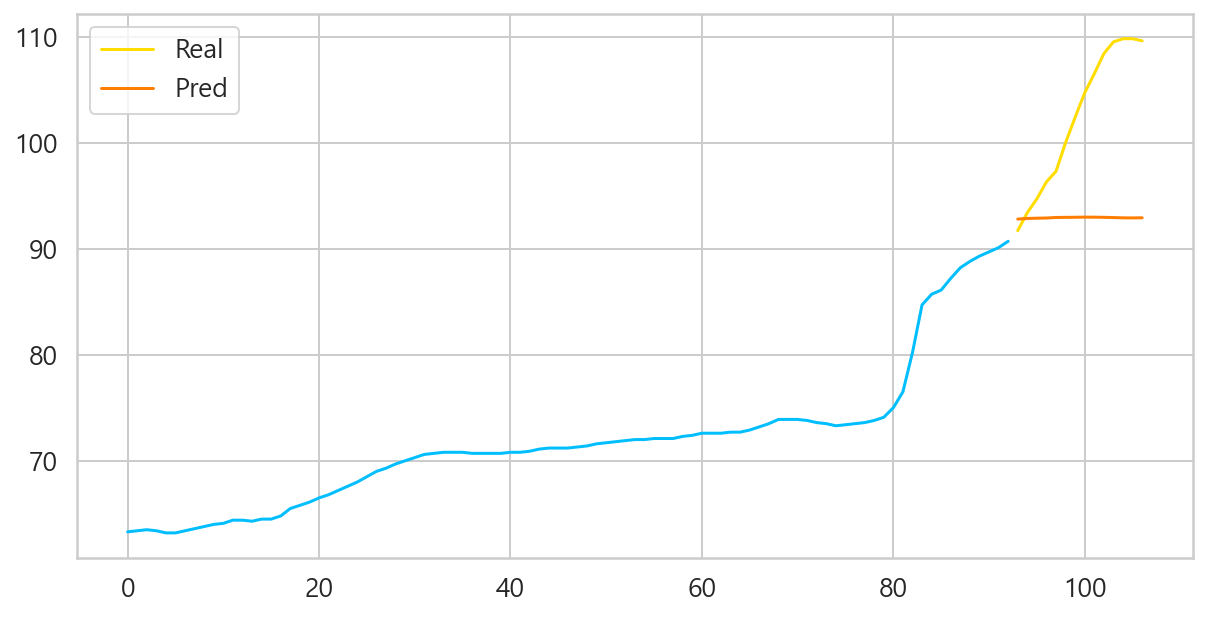

In [224]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [225]:
PATH = f'./model.pt'
torch.save(model, f'./model.pt')

In [226]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

Use all data for training

In [262]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = data['수원시']

In [263]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit_transform(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용

y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()


In [264]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (107, 64)
y_all :  (110,)


In [265]:
X_all :  (102, 331)
y_all :  (102,)
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [266]:
 model = CoronaVirusPredictor(
   n_features=n_features,
   n_hidden=n_hidden,
   seq_len=seq_length,
   n_layers=n_layers
 )
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.03494893014431
Epoch 10 train loss: 0.027718324214220047
Epoch 20 train loss: 0.022846965119242668
Epoch 30 train loss: 0.020114203914999962
Epoch 40 train loss: 0.019195517525076866
Epoch 50 train loss: 0.019144468009471893
Epoch 60 train loss: 0.019016915932297707
Epoch 70 train loss: 0.01881425455212593
Epoch 80 train loss: 0.01867559738457203
Epoch 90 train loss: 0.01846364326775074
Epoch 100 train loss: 0.01829436421394348
Epoch 110 train loss: 0.018054040148854256
Epoch 120 train loss: 0.01770917885005474
Epoch 130 train loss: 0.01723974384367466
Epoch 140 train loss: 0.016572657972574234
Epoch 150 train loss: 0.015878288075327873
Epoch 160 train loss: 0.014691836200654507
Epoch 170 train loss: 0.012731313705444336
Epoch 180 train loss: 0.010415039025247097
Epoch 190 train loss: 0.007139119319617748


Predicting future cases

In [267]:
test_seq

tensor([[[7.3200e+01, 6.4300e+01, 9.3767e+01, 7.9500e+01, 1.0129e+02,
          9.2823e+01, 5.4200e+00, 8.3554e+01, 7.6858e+01, 1.1010e+03,
          1.8677e+03, 1.9640e+03, 5.6387e+02, 9.7579e+06, 1.0650e+05,
          2.2790e+04, 7.3100e+01, 7.3200e+01, 7.3500e+01, 6.4225e+01,
          6.4425e+01, 6.4756e+01, 9.3550e+01, 9.3667e+01, 9.3900e+01,
          7.9600e+01, 7.9800e+01, 8.0100e+01, 1.0139e+02, 9.0009e+01,
          1.0287e+02, 9.2952e+01, 9.3038e+01, 9.2728e+01, 5.5400e+00,
          5.6600e+00, 5.7800e+00, 8.3163e+01, 8.2871e+01, 8.2689e+01,
          7.6377e+01, 7.6108e+01, 7.6008e+01, 1.1110e+03, 1.0830e+03,
          1.0890e+03, 1.8624e+03, 1.8571e+03, 1.8411e+03, 2.0049e+03,
          2.0265e+03, 1.9619e+03, 5.5502e+02, 5.3587e+02, 5.0367e+02,
          1.0160e+07, 7.2684e+06, 8.4137e+06, 8.7563e+04, 6.5640e+04,
          5.4632e+04, 1.7718e+04, 1.4925e+04, 1.3631e+04]]])

In [268]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [250]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [251]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[72.0209710329771,
 72.02089464962482,
 72.02083215415477,
 72.02078076899052,
 72.02073910534382,
 72.02070577442646,
 72.02067938745022,
 72.02065716683865,
 72.02064050137997,
 72.02062591910362,
 72.02061480879784,
 72.02060508728027,
 72.02059744894505,
 72.02059119939804]

In [253]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1, freq = 'MS',
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.DataFrame(
  data=predicted_cases,
  index=predicted_index
)
predicted_cases

,0
2022-03-01,72.020971
2022-04-01,72.020895
2022-05-01,72.020832
2022-06-01,72.020781
2022-07-01,72.020739
2022-08-01,72.020706
2022-09-01,72.020679
2022-10-01,72.020657
2022-11-01,72.020641
2022-12-01,72.020626


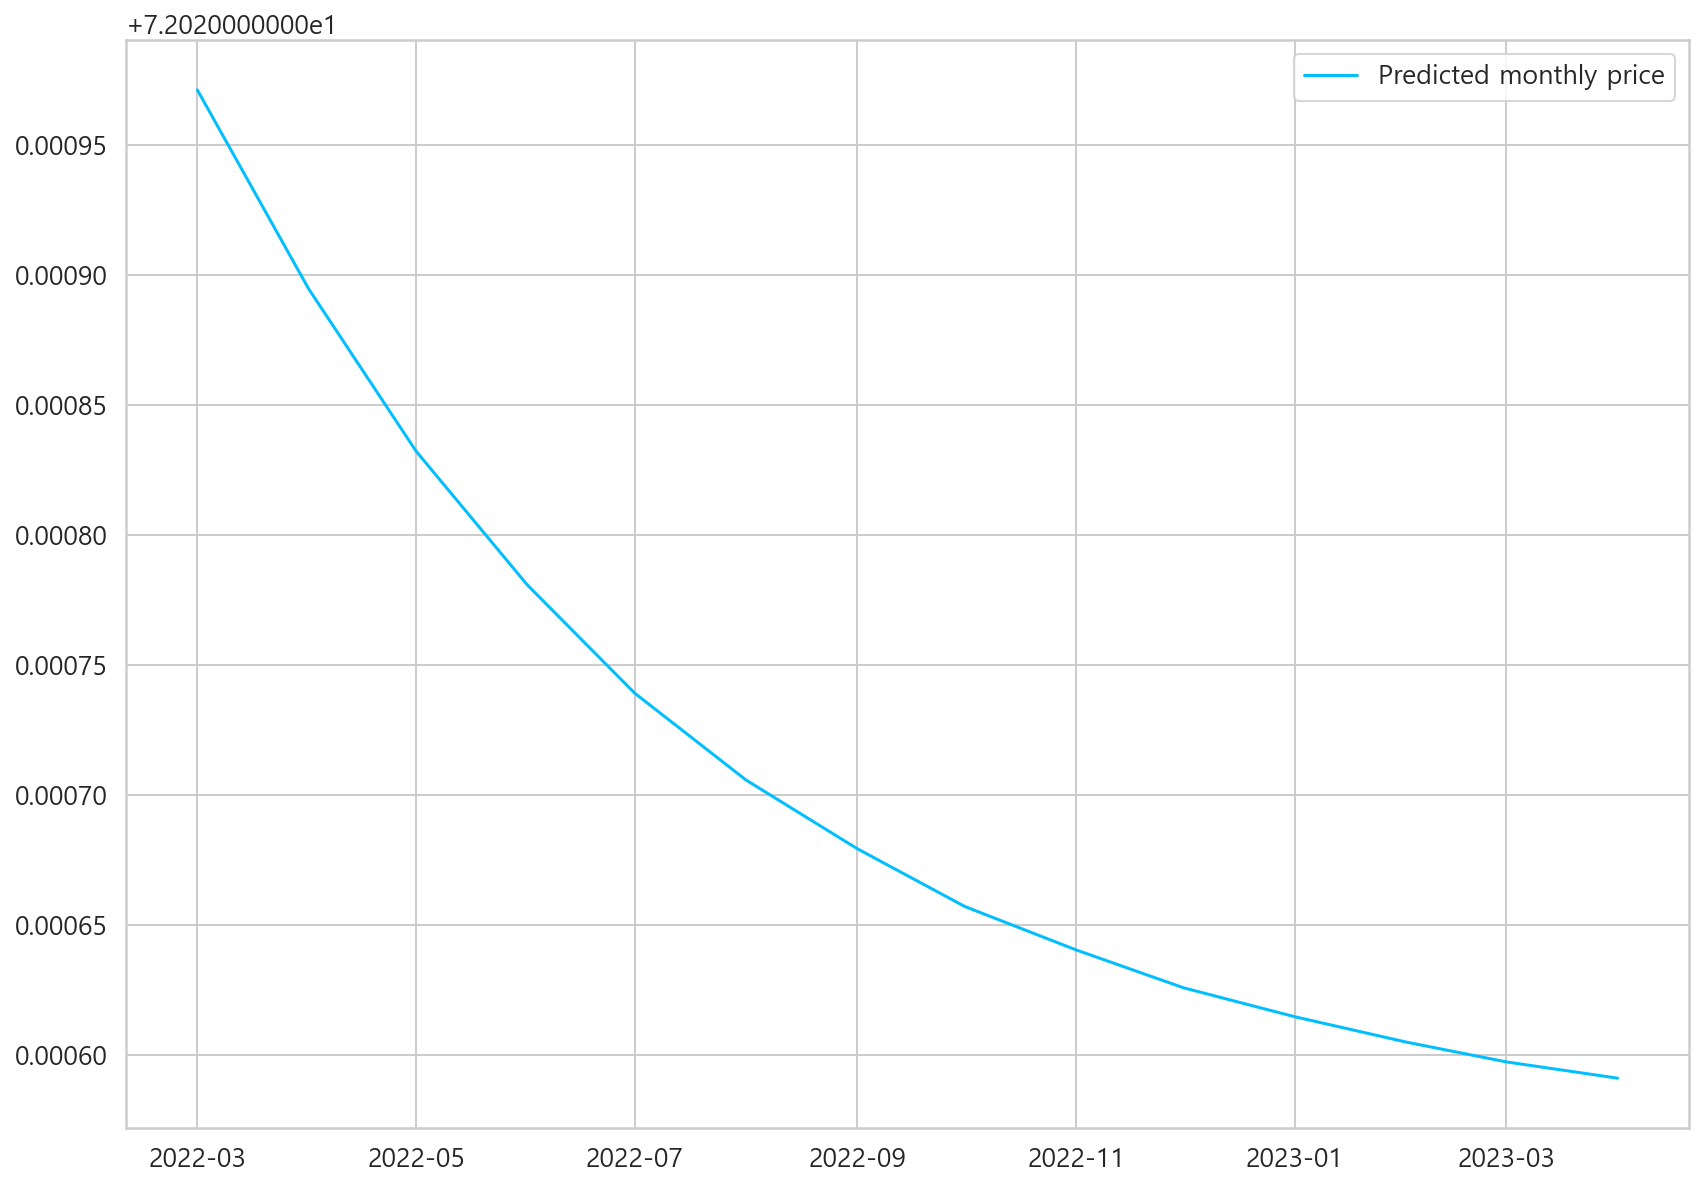

In [254]:
plt.plot(predicted_cases, label='Predicted monthly price')
plt.legend();

In [255]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [256]:
preds_

,0
2022-03-01,72.020971
2022-04-01,72.020895
2022-05-01,72.020832
2022-06-01,72.020781
2022-07-01,72.020739
2022-08-01,72.020706
2022-09-01,72.020679
2022-10-01,72.020657
2022-11-01,72.020641
2022-12-01,72.020626


In [ ]:
y = pd.DataFrame(data =data['수원시'][-107:].values,index = df.index[-107:])
y.index.name = ''
y

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(y,label='real')
plt.plot(preds_, label='predict')
plt.xticks(rotation=90)


plt.legend()